In [97]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
import sys
import pandas as pd
import pickle
from scipy import stats

from doublet_quantifier.curvefit import *
from doublet_quantifier.models import *


In [98]:
sys.path.append('/Users/allybaldelli/Desktop/AMNH-stuff/quantifying_clouds_ally/functions')
from plotting_tools import *

In [99]:
mypath = '/Users/allybaldelli/Desktop/AMNH-stuff/quantifying_clouds_ally/'
dfs = []
temps = [1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400]

for temp in temps:
    with open(mypath + "diamondback-data/pickle_files/parameters/t"+ str(temp) + "_parameter_df.pkl", "rb") as f:
        df = pickle.load(f)
        df["temp"] = temp * np.ones(len(df))
        dfs.append(df[df['clouds'] != 10].copy(deep=False).reset_index(drop=True)) # remove no cloud models

master_df = pd.concat(dfs, ignore_index=True)
[T1600, T1700, T1800, T1900, T2000, T2100, T2200, T2300, T2400] = dfs

del df

In [100]:
# lists of values 

gravities = [3.5, 4.0, 4.5, 5.0, 5.5]
clouds = [1,2,3,4,8]


In [101]:
# Fili15 spectral type to temperature conversion
# integer values 6-29 correspond to spectral types M6-T9
# L0:10, L1:11, L2:12, L3:13, L4:14, L5:15, L6:16, L7:17, L8:18, L9:19
Teff = lambda x: 4.747e3 -7.005e2*x + 1.155e2*(x**2) - 1.191e1*(x**3) +6.318e-1*(x**4) -1.606e-2*(x**5) +1.546e-4*(x**6)


In [102]:
# defing the colors and colorbars for the logg and temp values 
logg_num = [3.5, 4, 4.5, 5, 5.5]
logg_ticks = ['Less\ndense', '4', '4.5', '5', 'More\ndense']
logg_bounds = [3.25, 3.75, 4.25, 4.75, 5.25, 5.75]

temp_num =   [ 1600, 1800, 2000, 2200, 2400]
temp_ticks = ['1600 K', '1800 K', '2000 K', '2200 K','2400 K']


spec_types = ["L5", "L4", "L3", "L2", "L1", "L0", " M9"]
spec_ticks = [Teff(type) for type in range(15, 9-1, -1)]

temp_bounds = [1550, 1650, 1750, 1850, 1950, 2050, 2150, 2250, 2350, 2450]

bw_cmap = plt.cm.binary
norm_bw = mpl.colors.BoundaryNorm(logg_bounds, logg_colors.N, extend='min')


rainbow = plt.cm.Spectral_r
norm_temp = mpl.colors.BoundaryNorm(temp_bounds, rainbow.N, extend='neither')


def logg_bw_colorbar(fig, cax = None, ax = None, orientation='vertical',
                 shrink=1.0, aspect=20, pad=.14, fontsize = 12):

    cbar = fig.colorbar(pl.cm.ScalarMappable(norm=norm_bw, cmap=bw_cmap),
                cax=cax, ax = ax, orientation= orientation,
                extend='neither', spacing='proportional',
                shrink=shrink, aspect=aspect, pad=pad)
    cbar.ax.yaxis.set_ticks(logg_num)
    cbar.ax.yaxis.set_ticklabels(logg_ticks, fontsize = fontsize)

    return cbar



def temp_colorbar(fig, cax = None, ax = None, orientation='vertical',
                  shrink=1.0, aspect=20, pad=.14, fontsize = 12, labels = False):
    cbar = fig.colorbar(pl.cm.ScalarMappable(norm=norm_temp, cmap=rainbow),
                cax=cax, ax = ax, orientation= orientation,
                extend='neither', spacing='proportional',
                shrink=shrink, aspect=aspect, pad=pad)
    # Add ticks and labels to both sides of the color bar
    cbar.ax.yaxis.set_ticks_position('both')

    # Set ticks and labels for the left side
    left_ticks = spec_ticks
    left_tick_labels = spec_types
    cbar.ax.yaxis.set_ticks(left_ticks)
    cbar.ax.yaxis.set_ticklabels(left_tick_labels, fontsize = fontsize)
    cbar.ax.yaxis.set_label_position('left')
    if labels:
        cbar.set_label("Spectral Type", fontsize = fontsize + 1, labelpad=0)

    # Create secondary axis for the right side ticks
    cbar_ax_secondary = cbar.ax.twinx()
    cbar_ax_secondary.set_ylim(cbar.ax.get_ylim())


    # Set ticks and labels for the right side
    right_ticks = temp_num 
    right_tick_labels = temp_num
    cbar_ax_secondary.set_yticks(right_ticks)
    cbar_ax_secondary.set_yticklabels(right_tick_labels, fontsize = fontsize -1)
    cbar_ax_secondary.yaxis.set_label_position('right')
    if labels:
        cbar_ax_secondary.set_ylabel("Temperature (K)", fontsize = fontsize + 1, labelpad= 10)
    

    return cbar
    

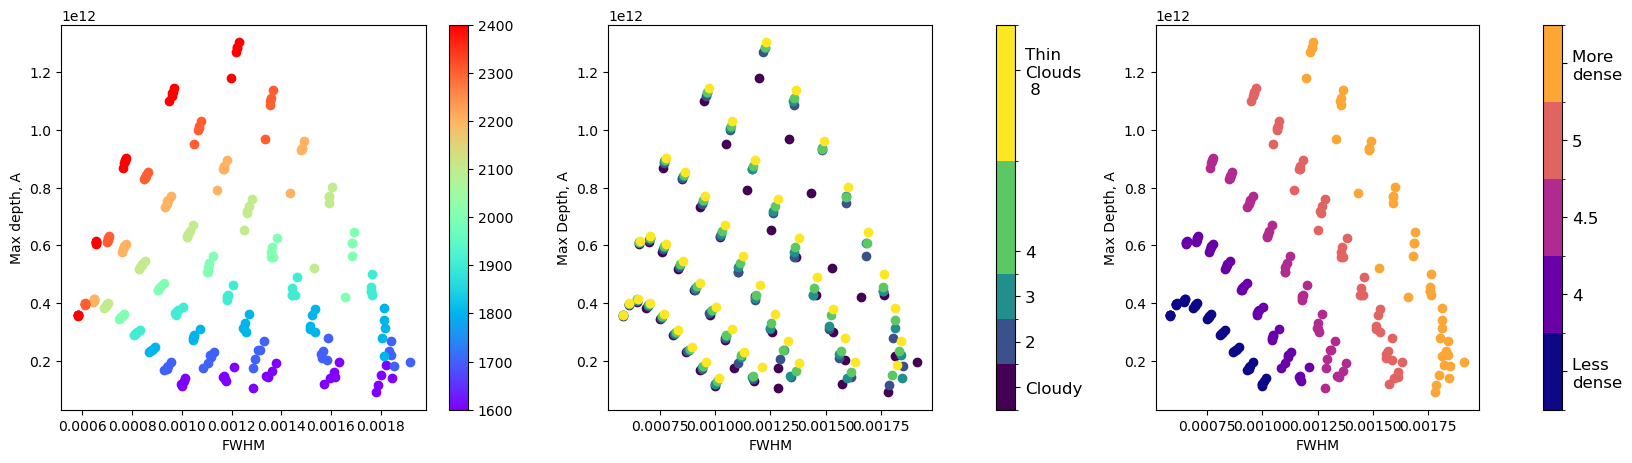

In [103]:
## shape of doublet plots: various color coding

fig, axs = plt.subplots(1, 3, figsize = (20, 5))
ax1, ax2, ax3 = axs


# colored by temperature
cmap = plt.cm.rainbow
norm = mcolors.Normalize(vmin=min(temps), vmax=max(temps))


for temp in temps:
    mask = master_df['temp'] == temp
    # mask = mask & (master_df['logg'] >= 4) & (master_df['logg'] <= 5)
    #mask = mask & (master_df['clouds'] <= 3)
    color = cmap(norm(temp))
    
    ax1.scatter( (master_df[mask]['FWHM1'] + master_df[mask]['FWHM2'])/2, 
               -(master_df[mask]['A1'] + master_df[mask]['A2'])/2,
                color = color)
    
ax1.set_xlabel('FWHM')
ax1.set_ylabel('Max depth, A')
temp_colorbar(fig, ax = ax1)

# colored by fsed
for fsed in clouds:
    mask = round(master_df['clouds'], 1) == fsed
    mask = mask & (master_df['temp'] >= 1300) & (master_df['logg'] <= 2400)
    color = fsed_colors(norm_f(fsed))
    
    ax2.scatter( (master_df[mask]['FWHM1'] + master_df[mask]['FWHM2'])/2, 
               -(master_df[mask]['A1'] + master_df[mask]['A2'])/2,
                color = color)
    
    
ax2.set_xlabel('FWHM')
ax2.set_ylabel('Max Depth, A')
fsed_colorbar(fig, ax = ax2)



# colored by logg
for g in gravities:
    mask = round(master_df['logg'], 1) == g
    mask = mask & (master_df['temp'] >= 1300) & (master_df['logg'] <= 2400)
    color = logg_colors(norm_g(g))
    
    ax3.scatter( (master_df[mask]['FWHM1'] + master_df[mask]['FWHM2'])/2, 
               -(master_df[mask]['A1'] + master_df[mask]['A2'])/2,
                color = color)
    
ax3.set_xlabel('FWHM')
ax3.set_ylabel('Max Depth, A')

logg_colorbar(fig, ax = ax3)

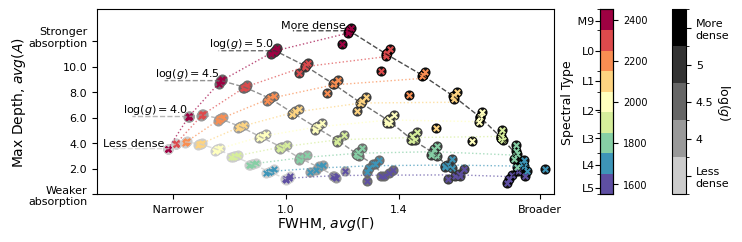

In [104]:


# wide version of research note plot
ticks_font_size = 8
labels_font_size = 10

## size of the plot for research note
temperature_lines = True
gravity_lines = True
annotating_gravity = True
grav_annotations =[r'$\log(g) = $' + str(g) + ' ' for g in gravities]
grav_annotations[0] = 'Less dense '
grav_annotations[-1] = 'More dense '

# starting plot
fig = plt.figure(figsize=(7.6, 2.4))
gs = fig.add_gridspec(1, 5,width_ratios=[1, 0.01, 0.03, 0.04, 0.03])

ax = fig.add_subplot(gs[0, 0])
cax1, cax2 = fig.add_subplot(gs[0, 2]), fig.add_subplot(gs[0, 4]) 


# plotting lines for temperatures
if temperature_lines == True:
    for temp in temps:
        avg_A = []
        max_A = []
        min_A = []
        avg_FWHM = []
        mask_temp = master_df['temp'] == temp
        color = rainbow(norm_temp(temp))
        for g in gravities:
            mask_grav = round(master_df['logg'], 1) == g
            mask = mask_temp & mask_grav
            avg_A.append(np.mean(master_df[mask]['A1'] + master_df[mask]['A2'])/2)
            max_A.append(np.max(-(master_df[mask]['A1'] + master_df[mask]['A2']))/2)
            min_A.append(np.min(-(master_df[mask]['A1'] + master_df[mask]['A2']))/2)
            avg_FWHM.append(np.mean(master_df[mask]['FWHM1'] + master_df[mask]['FWHM2'])/2)
        #ax.fill_between(avg_FWHM, min_A, max_A, alpha=0.2, color=color)
        ax.plot(avg_FWHM, -np.array(avg_A), color = color, lw = 1, alpha = .7, linestyle = 'dotted')

# plotting lines for gravity
if gravity_lines == True:
    for i, g in  enumerate(gravities):
        avg_A = []
        avg_FWHM = []
        color = bw_cmap(norm_bw(g))
        mask_grav = round(master_df['logg'], 1) == g
        for temp in temps:
            mask_temp = master_df['temp'] == temp
            mask = mask_temp & mask_grav
            avg_A.append(np.median(master_df[mask]['A1'] + master_df[mask]['A2'])/2)
            avg_FWHM.append(np.median(master_df[mask]['FWHM1'] + master_df[mask]['FWHM2'])/2)
        
        # extending the lines and annotating the logg values
        if annotating_gravity:
            avg_A.append(avg_A[-1]) # - (avg_A[-2] - avg_A[-1]))
            avg_FWHM.append(avg_FWHM[-1] - (.2e-3))
            ax.annotate(grav_annotations[i], (avg_FWHM[-2], -avg_A[-2]), fontsize=8, color = 'k', ha='right', va='bottom')

        ax.plot(avg_FWHM, -np.array(avg_A), color = color, lw = 1, alpha = .7, linestyle = 'dashed')

        
# plotting black and white point for gravities        
for g in gravities:
    mask = round(master_df['logg'], 1) == g
    mask = mask & (master_df['temp'] >= 1400) & (master_df['logg'] <= 2400)
    color = bw_cmap(norm_bw(g))
    ax.scatter( (master_df[mask]['FWHM1'] + master_df[mask]['FWHM2'])/2, 
               -(master_df[mask]['A1'] + master_df[mask]['A2'])/2,
                color = color, s=40, alpha = .9)
    
# plotting colored points for temperatures
for temp in temps:
    mask = master_df['temp'] == temp
    color = rainbow(norm_temp(temp))
    ax.scatter( (master_df[mask]['FWHM1'] + master_df[mask]['FWHM2'])/2, 
                - (master_df[mask]['A1'] + master_df[mask]['A2'])/2,
                    color = color, alpha = 1, s=15, marker = 'x')
        
        
# creating temperture colorbar
temp_cb = temp_colorbar(fig, cax = cax1, pad= 50, fontsize=ticks_font_size, shrink = 0.5)
# temp_cb.ax.set_title('Temperature (K)\nSpectral Type', fontsize=9, pad= 2)
# temp_cb.ax.set_label('Temperature (K)\nSpectral Type') #, fontsize=9, pad= 2)
temp_cb.set_label('Spectral Type', labelpad=0, fontsize=9)
temp_cb.ax.tick_params(axis='both', which='major', pad=0)


# creating logg colorbar
bw_cb = logg_bw_colorbar(fig, cax = cax2, pad= 100, fontsize=ticks_font_size)
bw_cb.ax.set_xticks([])
bw_cb.set_label(r'$\log(g)$', fontsize=9, labelpad=2, rotation = -90) 

# set limits and ticks for the y axis
ax.set_ylim(-20, 14.5e11)
yticks = np.array([0, 2e11, 4e11, 6e11, 8e11, 10e11, 12e11])
ylabel = list(yticks.copy()/1e11)
ylabel[-1] = "Stronger\nabsorption\n"
ylabel[0] = "Weaker\nabsorption"
ax.set_yticks(yticks)
ax.set_yticklabels(ylabel, fontsize= ticks_font_size)


# set limits and ticks for the x axis
ax.set_xlim(0.33e-3, 1.95e-3)
xticks = np.array([0.6e-3, 1e-3, 1.4e-3, 1.9e-3])
xlabel = list(np.around(xticks.copy()/1e-3, 1))
xlabel[-1] = "Broader"
xlabel[0] = "   Narrower"
ax.set_xticks(xticks)
ax.set_xticklabels(xlabel, fontsize= ticks_font_size)


# set axis labels
ax.set_ylabel("Max Depth, $avg(A)$", fontsize=labels_font_size, labelpad=0)
ax.set_xlabel("FWHM, $avg(Γ)$", fontsize=labels_font_size, labelpad=0) 
 
# save the figure
fig.savefig('/Users/allybaldelli/Desktop/AMNH-stuff/quantifying_clouds_ally/plots/Wide_TempMap.pdf',  bbox_inches='tight', pad_inches=0.01)
# ax.set_title(r"$T_{eff} = 1600 \text{K}$", fontsize=12)

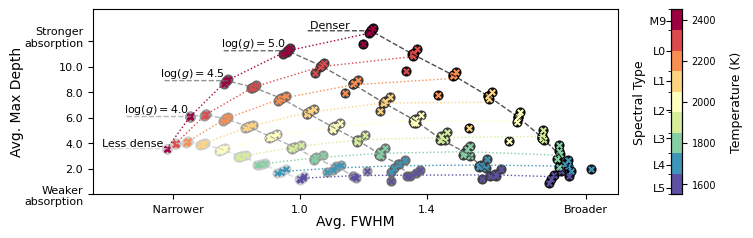

In [105]:
# wide version of research note plot no log bar
ticks_font_size = 8
labels_font_size = 10

## size of the plot for research note
temperature_lines = True
gravity_lines = True
annotating_gravity = True
grav_annotations =[r'$\log(g) = $' + str(g) + ' ' for g in gravities]
grav_annotations[0] = 'Less dense '
grav_annotations[-1] = 'Denser      '

# starting plot
fig = plt.figure(figsize=(7.6, 2.4))
gs = fig.add_gridspec(1, 2,width_ratios=[1, 0.02])

ax = fig.add_subplot(gs[0, 0])
cax1= fig.add_subplot(gs[0, 1])


# plotting lines for temperatures
if temperature_lines == True:
    for temp in temps:
        avg_A = []
        max_A = []
        min_A = []
        avg_FWHM = []
        mask_temp = master_df['temp'] == temp
        color = rainbow(norm_temp(temp))
        for g in gravities:
            mask_grav = round(master_df['logg'], 1) == g
            mask = mask_temp & mask_grav
            avg_A.append(np.mean(master_df[mask]['A1'] + master_df[mask]['A2'])/2)
            max_A.append(np.max(-(master_df[mask]['A1'] + master_df[mask]['A2']))/2)
            min_A.append(np.min(-(master_df[mask]['A1'] + master_df[mask]['A2']))/2)
            avg_FWHM.append(np.mean(master_df[mask]['FWHM1'] + master_df[mask]['FWHM2'])/2)
        #ax.fill_between(avg_FWHM, min_A, max_A, alpha=0.2, color=color)
        ax.plot(avg_FWHM, -np.array(avg_A), color = color, lw = 1, alpha = 1, linestyle = 'dotted')

# plotting lines for gravity
if gravity_lines == True:
    for i, g in  enumerate(gravities):
        avg_A = []
        avg_FWHM = []
        color = bw_cmap(norm_bw(g))
        mask_grav = round(master_df['logg'], 1) == g
        for temp in temps:
            mask_temp = master_df['temp'] == temp
            mask = mask_temp & mask_grav
            avg_A.append(np.median(master_df[mask]['A1'] + master_df[mask]['A2'])/2)
            avg_FWHM.append(np.median(master_df[mask]['FWHM1'] + master_df[mask]['FWHM2'])/2)
        
        # extending the lines and annotating the logg values
        if annotating_gravity:
            avg_A.append(avg_A[-1]) # - (avg_A[-2] - avg_A[-1]))
            avg_FWHM.append(avg_FWHM[-1] - (.2e-3))
            ax.annotate(grav_annotations[i], (avg_FWHM[-2], -avg_A[-2]), fontsize=8, color = 'k', ha='right', va='bottom')

        ax.plot(avg_FWHM, -np.array(avg_A), color = color, lw = 1, alpha = .7, linestyle = 'dashed')

        
# plotting black and white point for gravities        
for g in gravities:
    mask = round(master_df['logg'], 1) == g
    mask = mask & (master_df['temp'] >= 1400) & (master_df['logg'] <= 2400)
    color = bw_cmap(norm_bw(g))
    ax.scatter( (master_df[mask]['FWHM1'] + master_df[mask]['FWHM2'])/2, 
               -(master_df[mask]['A1'] + master_df[mask]['A2'])/2,
                color = color, s=40, alpha = .9)
    
# plotting colored points for temperatures
for temp in temps:
    mask = master_df['temp'] == temp
    color = rainbow(norm_temp(temp))
    ax.scatter( (master_df[mask]['FWHM1'] + master_df[mask]['FWHM2'])/2, 
                - (master_df[mask]['A1'] + master_df[mask]['A2'])/2,
                    color = color, alpha = 1, s=15, marker = 'x')
        
        
# creating temperture colorbar
temp_cb = temp_colorbar(fig, cax = cax1, pad= 50, fontsize=ticks_font_size, shrink = 0.5, labels= True)
# temp_cb.ax.set_title('Temperature (K)\nSpectral Type', fontsize=9, pad= 2)
# temp_cb.ax.set_label('Temperature (K)\nSpectral Type') #, fontsize=9, pad= 2)
#temp_cb.set_label('Spectral Type', labelpad=0, fontsize=9)
temp_cb.ax.tick_params(axis='both', which='major', pad=0)


# # creating logg colorbar
# bw_cb = logg_bw_colorbar(fig, cax = cax2, pad= 100, fontsize=ticks_font_size)
# bw_cb.ax.set_xticks([])
# bw_cb.set_label(r'$\log(g)$', fontsize=9, labelpad=2, rotation = -90) 

# set limits and ticks for the y axis
ax.set_ylim(-20, 14.5e11)
yticks = np.array([0, 2e11, 4e11, 6e11, 8e11, 10e11, 12e11])
ylabel = list(yticks.copy()/1e11)
ylabel[-1] = "Stronger\nabsorption\n"
ylabel[0] = "Weaker\nabsorption"
ax.set_yticks(yticks)
ax.set_yticklabels(ylabel, fontsize= ticks_font_size)


# set limits and ticks for the x axis
ax.set_xlim(0.35e-3, 2.00e-3)
xticks = np.array([0.6e-3, 1e-3, 1.4e-3, 1.9e-3])
xlabel = list(np.around(xticks.copy()/1e-3, 1))
xlabel[-1] = "Broader"
xlabel[0] = "   Narrower"
ax.set_xticks(xticks)
ax.set_xticklabels(xlabel, fontsize= ticks_font_size)


# set axis labels
ax.set_ylabel("Avg. Max Depth", fontsize=labels_font_size, labelpad=0)
ax.set_xlabel("Avg. FWHM", fontsize=labels_font_size, labelpad=0) 
 
# save the figure
fig.savefig('/Users/allybaldelli/Desktop/AMNH-stuff/quantifying_clouds_ally/plots/Wide_TempMap.pdf',  bbox_inches='tight', pad_inches=0.01)
# ax.set_title(r"$T_{eff} = 1600 \text{K}$", fontsize=12)